In [1]:
#librerie
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab import drive
from scipy import integrate
from time import sleep
from scipy.optimize import curve_fit

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_to_file="drive/MyDrive/Lab HPGE/Data/Ge_Cs137_2000_1.xml"  #change this 



tree = ET.parse(path_to_file) 
root=tree.getroot()

In [4]:
list=[]

#output of the code below: a list of events and each event is a list of 8192 samples  

for event in root.findall("event"):  #this finds all the event in the file
    string_event=event.find("trace").text  #this takes all the samples for each event
    int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
    list.append(int_event)
    #if(len(list)>15000):
    #   break         

In [5]:
sample_space=10e-9 #10 ns
samples_per_event=len(list[0]) # 8192

evento=75 #pick an event to plot below

time_axis=np.linspace(sample_space,samples_per_event*sample_space,samples_per_event)  # from 10 ns to 8192*10 ns 
samples_axis=np.linspace(1,len(list[evento]),num=len(list[evento])) # from 1 to 8192

In [6]:
list_event=np.array(list) # casting to a numpy array

Saturation problem below


In [7]:
saturation_point=16383 #limit points saturation

#find the maximum of each event
maxima_peaks=np.zeros(len(list))
list_event.max(axis=1,out=maxima_peaks)

#find the index of each event that has a saturation problem
index_saturated=[i for i in range(len(maxima_peaks)) if(maxima_peaks[i]==saturation_point)]

print("There are ",len(index_saturated), "events in this run.")

There are  1198 events in this run.


In [8]:
def gaussian(x, N, mu,sigma):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)

flag=0 #if 0 the saturated events will be overwritten in the same array, otherwise saturated events will be filled 

threshold_value=50 #select a portion of the event that has a signal discarding samples below the threshold level
saturated_events_fitted=np.zeros((len(list_event),len(list_event[0]))) 

for index_event in index_saturated: #cycle on saturated events
    event=list_event[index_event] #select the event 
    sx=[]
    dx=[]
    graph_sx=[]
    graph_dx=[]
    small_points_dx=[]
    small_points_sx=[]
    plateau_points=[]

    plateau_points=[i for i in range(len(event)) if(event[i]==saturation_point)] #range of x_points where the plateau is located

    len_Plateau=len(plateau_points)

    
    #             _________________
    #            /|               |\
    #           / |               | \
    # ---------/---------------------\-------------------
    #_________/   |               |   \______________
    #         |   |    plateau    |   |
    #         |   |               |   |
    # small   |   |___            |   |_     small points
    # points  | graph |           |graph|       dx
    #  sx     |   sx  |           | dx  |
    #
    #

    small_points_sx=[i for i in range(len(event)) if(event[i]<threshold_value and i<plateau_points[0])]
    sx=[i for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
    dx=[i for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
    graph_sx=[event[i] for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
    graph_dx=[event[i] for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
    small_points_dx=[i for i in range(len(event)) if(event[i]<threshold_value and i>plateau_points[0])]

    #filling the right arrays
    x_graph=np.zeros(len(sx)+len(dx))
    np.concatenate((sx,dx),out=x_graph)
    graph=np.zeros(len(graph_sx)+len(graph_dx))
    np.concatenate((graph_sx,graph_dx),out=graph)

    #fitting 
    try:
        init_vals = [saturation_point,plateau_points[int(len(plateau_points)/2)] ,len(plateau_points)]  # for [N,mu, wid]
        best_vals, covar = curve_fit(gaussian, x_graph, graph,p0=init_vals) 

        gaussian_event=gaussian(samples_axis,best_vals[0],best_vals[1],best_vals[2])
    except:
        list_event[index_event]=list_event[index_event]
#    if(index_event==6):
#        plt.plot(samples_axis,gaussian(samples_axis,best_vals[0],best_vals[1],best_vals[2]))
#        plt.plot(x_graph,graph,ls="",marker=".")

    #filling the final array:
    if(flag==0):
        list_event[index_event]=gaussian_event
    else:
        saturated_events_fitted[index_event]=gaussian_event


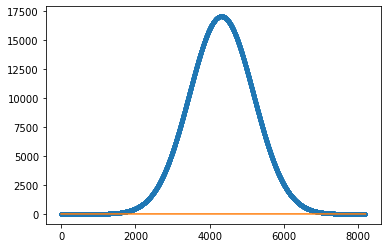

In [9]:
numb_event=162
plt.plot(samples_axis,list_event[numb_event],ls="",marker=".")
plt.plot(samples_axis,saturated_events_fitted[numb_event])

In [10]:
values_integrals=[integrate.trapz(event,time_axis) for event in list_event] #evaluating the spectrum

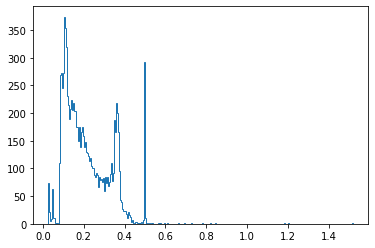

In [18]:
#histogram of the spectrum
numb_bins=300 #try to change this maybe

plt.hist(values_integrals,bins=numb_bins,histtype="step")
#plt.ylim(0,10)   #to cut the y axis 
#plt.xlim(0.,0.9)

plt.show()
